<a href="https://colab.research.google.com/github/ARAVIND2017/gncipl-internship/blob/main/final%20project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet datasets transformers torch gradio scikit-learn pandas matplotlib

In [ ]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
import numpy as np
import gradio as gr
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train shape: (25000, 2)
                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


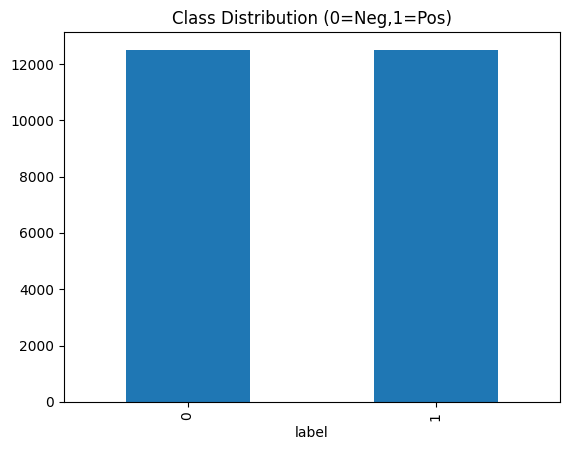

In [ ]:
dataset = load_dataset("imdb")
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

print("Train shape:", train_df.shape)
print(train_df.head())

# Class balance visualization
train_df['label'].value_counts().plot(kind="bar", title="Class Distribution (0=Neg,1=Pos)")
plt.show()

In [ ]:
from transformers import pipeline, set_seed

generator = pipeline("text-generation", model="distilgpt2")
set_seed(42)

synthetic_texts, synthetic_labels = [], []

# Generate 200 synthetic reviews (100 pos + 100 neg)
for _ in range(100):
    g = generator("This movie was amazing", max_length=50, do_sample=True)[0]['generated_text']
    synthetic_texts.append(g)
    synthetic_labels.append(1)
for _ in range(100):
    g = generator("This movie was terrible", max_length=50, do_sample=True)[0]['generated_text']
    synthetic_texts.append(g)
    synthetic_labels.append(0)

print("Synthetic samples:", len(synthetic_texts))
print(synthetic_texts[:2])



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/m

Synthetic samples: 200
["This movie was amazing!\n\nI was sitting in the living room with my wife and I had a great movie and it just really broke. I was surprised when I saw it.\nThat movie was made and it's got a movie as big as The Matrix 2 and it's not as big as the Matrix 3. I just wanted to watch it.\nI bought it for $10 today. I was really happy with it, I bought it with no other reason than to watch the movie! I can't wait to watch it again.\nI'm so excited to see it! It was a great movie! I'm so excited to see it!\nThe movie is so great. I love watching it, I love hearing about it.\nI'm so happy to see it! It was a great movie! I'm so excited to see it! It was a great movie! I'm so excited to see it! It was a great movie! I'm so excited to see it! It was a great movie! I'm so excited to see it! It was a great movie! I'm so excited to see it! It was a great movie! I'm so excited to see it! It was a great movie! I'm so excited to see it! It was", 'This movie was amazing. It was 

In [ ]:
texts = train_df['text'].tolist() + synthetic_texts
labels = train_df['label'].tolist() + synthetic_labels

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize all texts
encodings = tokenizer(texts, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(list(test_df['text']), truncation=True, padding=True, max_length=256)

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = IMDbDataset(encodings, labels)
test_dataset = IMDbDataset(test_encodings, test_df['label'].tolist())

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

In [ ]:
!pip install --upgrade transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 50.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.0
    Uninstalling transformers-4.56.0:
      Successfully uninstalled transformers-4.56.0


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'train_dataset' is not defined

In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
def predict_sentiment(text):
    if not text.strip():
        return "Please enter some text!"
    result = sentiment_pipeline(text)[0]
    label = "Positive 😊" if result['label'] == "LABEL_1" else "Negative 😡"
    score = result['score']
    return f"{label} (Confidence: {score:.2f})"

demo = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=3, placeholder="Type any text here..."),
    outputs="text",
    title="Enhanced Sentiment Analysis with GPT2 Augmentation",
    description="Fine-tuned on real + GPT2-generated reviews. Works well for arbitrary text like 'hi', 'okay', etc."
)

demo.launch(share=True)